In [1]:
import pickle
import pandas as pd
from collections import defaultdict
import numpy as np
import datetime

In [2]:
# Load Data
with open('song_users_all.json','rb') as f:
    song_users = pickle.load(f)
with open('user_songs_train.json','rb') as f:
    user_songs_train = pickle.load(f)
with open('user_songs_test.json','rb') as f:
    user_songs_test = pickle.load(f)
with open('ratings_train.json','rb') as f:
    ratings_train = pickle.load(f)
with open('ratings_test.json','rb') as f:
    ratings_test = pickle.load(f)
with open('user_song_ratings.json','rb') as f:
    ratings_all = pickle.load(f)


In [3]:
user_songs_train[7]

[0,
 280,
 511,
 992,
 993,
 1192,
 1289,
 1331,
 1579,
 1590,
 1599,
 1600,
 1677,
 1689,
 1918,
 1976,
 2155,
 2248,
 2396,
 2419]

In [4]:
user_songs_test[7]

[1787, 1397, 2136, 2388, 2261]

In [5]:
#ratings_train[(7,469)]

In [6]:
# PAREMETERS K, limit

In [7]:
# USER-to-user collabortaive filtering : choose the items for the user because 
# those items have been liked by similar users
# Item-to-item collaborative filtering: choose the items for a user, because the user 
# has liked similar items in the past
# to choose the user to recommened to item j, I can look at other item j' 
# who liked the same users as item j
# if items j and j' are similar 
# given a user, calculate scores for each item O(N^2M)
# there are M^2 item-item weights and each vector is N length

In [8]:
def ub_cf(limit):
    '''number of songs two users have in common. This function finds the first 30 neighboors'''
    K=30
    averages = {} # each user average use
    deviations = defaultdict(list)
    neighboors = defaultdict(list)
    # for every user (i)
    # we collect ratings for each song rated by user i
    # we find an average rating for all songs per user i
    # we find a rating deviation per each song  for user i
    # if correlation btw two users is large, they like/dislike the same song 
    # SIM(Ui, Uj) is correlation between those users
    
    for i in user_songs_train.keys():
        songs_i = user_songs_train[i]
        songs_i_set = set(songs_i)
        ratings_i = {s: ratings_all[(i, s)] for s in songs_i}
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = {s:(r - avg_i) for s, r in ratings_i.items()}
        dev_i_values = np.array(list(dev_i.values()))
        sigma_i = np.sqrt(np.dot(dev_i_values, dev_i_values))
        averages[i] = avg_i
        deviations[i].append(dev_i)
        sl = []
        for j in user_songs_train.keys():
            if j!=i:
                songs_j = user_songs_train[j]
                songs_j_set = set(songs_j)
                common_songs = (songs_j_set)&(songs_i_set)
                if len(common_songs)>= limit:
                    ratings_j = {s:ratings_all[(j,s)] for s in songs_j}
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = {s:(r - avg_j) for s, r in ratings_j.items()}
                    dev_j_values = np.array(list(dev_j.values()))
                    sigma_j = np.sqrt(np.dot(dev_j_values, dev_j_values))
                    # correlation coefficiant
                    num = sum(dev_i[s]*dev_j[s] for s in common_songs)
                    wij = num / (sigma_i*sigma_j+0.000001)
                    #if wij < 0: wij = 0
                    sl.append((wij,j))
            else:
                continue
        sl.sort(reverse = True)
        neighboors[i].append(sl[0:K])
    return neighboors,deviations,averages

In [9]:
# LIMIT >= 3

t0 = datetime.datetime.now()
neighboors, deviations, averages = ub_cf(limit=3)
delta_limit4 = datetime.datetime.now()-t0
print("Time to find the neighboors where limit =3:", delta_limit4)

Time to find the neighboors where limit =3: 0:00:02.454627


In [10]:
# LIMIT >= 1

t0 = datetime.datetime.now()
neighboors1, deviations1, averages1 = ub_cf(limit=1)
delta_limit0 = datetime.datetime.now()-t0
print("Time to find the neighboors where limit =1:", delta_limit0)

Time to find the neighboors where limit =1: 0:00:16.134682


In [11]:
# no.of common songs >= 3, UserID = 7, K =15
neighboors[7][0][0:15]

[(0.15988550306060323, 561),
 (0.0680413632254637, 892),
 (0.023669050148584177, 8),
 (0.020942686642658553, 541),
 (0.0, 324),
 (0.0, 0),
 (-0.08570100650050827, 38)]

In [12]:
# no.of common songs >= 1, UserID = 7, K =15
neighboors1[7][0][0:15]

[(0.15988550306060323, 561),
 (0.11785108853110586, 810),
 (0.1163386124736487, 195),
 (0.06903822147115152, 100),
 (0.0680413632254637, 892),
 (0.06517948093566686, 2),
 (0.06384422893734279, 732),
 (0.06347958193912161, 190),
 (0.043033137180085355, 827),
 (0.027524085794828183, 5),
 (0.023669050148584177, 8),
 (0.020942686642658553, 541),
 (0.005336690756606877, 37),
 (0.0, 948),
 (0.0, 945)]

In [13]:
deviations[7]

[{0: 1.0,
  280: 0.0,
  511: -1.0,
  992: 1.0,
  993: 0.0,
  1192: -1.0,
  1289: 0.0,
  1331: 0.0,
  1579: 0.0,
  1590: 0.0,
  1599: 0.0,
  1600: 1.0,
  1677: 0.0,
  1689: 0.0,
  1918: 0.0,
  1976: 0.0,
  2155: 0.0,
  2248: 0.0,
  2396: -1.0,
  2419: 0.0}]

In [14]:
averages[7]

4.0

In [15]:
# predict function that takes in user 'i' and song 's'
# we use the ratings of the nearest neighboors j to predict the rating of user i

class predict_error(object):
    def __init__(self,k,neighboors,deviations,averages):
        self.k = k
        self.neighboors = neighboors
        self.deviations = deviations
        self.averages = averages
        
        
    def predict(self,i,s):
        numerator = 0
        denominator = 0
        for wij,j in self.neighboors[i][0][0:self.k]:
            try: 
                dev = self.deviations[j][0].get(s,0)
                numerator+=wij*dev
                denominator+=abs(wij)
            except KeyError:
                pass
        if denominator == 0:
            prediction = self.averages[i]
        elif denominator == 0 and numerator ==0:
            prediction = self.averages[i]
        else:
            prediction = self.averages[i]+numerator/denominator
        prediction = min(5, prediction)
        prediction = max(0.5, prediction)
        return prediction

    def mse(self, p,t):
        p = np.array(p)
        t = np.array(t)
        return np.mean((p-t)**2)
    
    def mae(self, p,t):
        p = np.array(p)
        t = np.array(t)
        return np.mean(abs(p-t))

    def train_error(self):
        train_predictions, train_targets = [], []
        for (i,s),r in ratings_train.items():
            predict_rating= self.predict(i,s)
            train_targets.append(r)
            train_predictions.append(predict_rating)
        mse_train = self.mse(train_predictions, train_targets)
        return mse_train
    
    def test_error(self):
        test_predictions, test_targets = [], []
        for (i,s),r in ratings_test.items():
            predict_rating_T= self.predict(i,s)
            test_targets.append(r)
            test_predictions.append(predict_rating_T)
        mse_test = self.mse(test_predictions, test_targets)
        return mse_test

In [16]:
#LIMIT >= 3, K = 1
t0 = datetime.datetime.now()
class_predict_k1= predict_error(1,neighboors,deviations,averages)
mae1 = class_predict_k1.train_error()
mae_1_test = class_predict_k1.test_error()
delta0_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=1:", delta0_limit5)

Time to predict where limit >=3 K=1: 0:00:00.145206


In [17]:
mae1, mae_1_test

(0.24746174307292565, 0.286541111124117)

In [18]:
#LIMIT >= 3, K = 3
t0 = datetime.datetime.now()
class_predict_k3= predict_error(3,neighboors,deviations,averages)
mae3 = class_predict_k3.train_error()
mae_3_test = class_predict_k3.test_error()
delta0_limit3 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=3:", delta0_limit3)

Time to predict where limit >=3 K=3: 0:00:00.179000


In [19]:
mae3, mae_3_test

(0.23869742971853972, 0.2817716302074372)

In [20]:
#LIMIT >= 3, K = 5
t0 = datetime.datetime.now()
class_predict_k5= predict_error(5, neighboors,deviations,averages)
mae5 = class_predict_k5.train_error()
mae_5_test = class_predict_k5.test_error()
delta0_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit>=3 K=5:", delta0_limit5)

Time to predict where limit>=3 K=5: 0:00:00.180228


In [21]:
mae5, mae_5_test

(0.23688737184585204, 0.27983300899202523)

In [22]:
#LIMIT >=3, K = 7
t0 = datetime.datetime.now()
class_predict_k7= predict_error(7, neighboors,deviations,averages)
mae7 = class_predict_k7.train_error()
mae_7_test = class_predict_k7.test_error()
delta0_limit7 = datetime.datetime.now()-t0
print("Time to predict where limit>=3 K=7:", delta0_limit7)

Time to predict where limit>=3 K=7: 0:00:00.241939


In [23]:
mae7, mae_7_test

(0.23628571409596374, 0.27977927137645064)

In [24]:
#LIMIT >=3, K = 10
t0 = datetime.datetime.now()
class_predict_k10= predict_error(10, neighboors,deviations,averages)
mae10 = class_predict_k10.train_error()
mae_10_test = class_predict_k10.test_error()
delta0_limit10 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=10:", delta0_limit10)

Time to predict where limit >=3 K=10: 0:00:00.258338


In [25]:
mae10, mae_10_test

(0.23505508938989111, 0.279790569782678)

In [26]:
t0 = datetime.datetime.now()
class_predict_k15= predict_error(15, neighboors,deviations,averages)
mae15 = class_predict_k15.train_error()
mae_15_test = class_predict_k15.test_error()
delta0_limit15 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=15:", delta0_limit15)

Time to predict where limit >=3 K=15: 0:00:00.284650


In [27]:
mae15, mae_15_test

(0.23473115591315513, 0.2804617385973389)

In [28]:
t0 = datetime.datetime.now()
class_predict_k20= predict_error(20, neighboors,deviations,averages)
mae20 = class_predict_k20.train_error()
mae_20_test = class_predict_k20.test_error()
delta0_limit20 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=20:", delta0_limit20)

Time to predict where limit >=3 K=20: 0:00:00.328768


In [29]:
mae20, mae_20_test

(0.23430416394494738, 0.28041657922126995)

In [30]:
#LIMIT = 1, K = 1
t0 = datetime.datetime.now()
class_predict_k1_T= predict_error(1,neighboors1,deviations1,averages1)
mae1_T = class_predict_k1_T.train_error()
mae_1_test_T = class_predict_k1_T.test_error()
delta1_limit1 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=1:", delta1_limit1)

Time to predict where limit =1 K=1: 0:00:00.163488


In [31]:
mae1_T, mae_1_test_T

(0.21922297924711695, 0.2784544149560049)

In [32]:
#LIMIT = 1, K = 3
t0 = datetime.datetime.now()
class_predict_k3_T= predict_error(3,neighboors1,deviations1,averages1)
mae3_T = class_predict_k3_T.train_error()
mae_3_test_T = class_predict_k3_T.test_error()
delta1_limit3 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=3:", delta1_limit3)

Time to predict where limit =1 K=3: 0:00:00.263646


In [33]:
mae3_T, mae_3_test_T

(0.20161783911755748, 0.2752836693223226)

In [34]:
#LIMIT = 1, K = 5
t0 = datetime.datetime.now()
class_predict_k5_T= predict_error(5,neighboors1,deviations1,averages1)
mae5_T = class_predict_k5_T.train_error()
mae_5_test_T = class_predict_k5_T.test_error()
delta1_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=5:", delta1_limit5)

Time to predict where limit =1 K=5: 0:00:00.339464


In [35]:
mae5_T, mae_5_test_T

(0.2013080267750688, 0.27479894633560076)

In [36]:
#LIMIT = 1, K = 5
t0 = datetime.datetime.now()
class_predict_k7_T= predict_error(7,neighboors1,deviations1,averages1)
mae7_T = class_predict_k7_T.train_error()
mae_7_test_T = class_predict_k7_T.test_error()
delta1_limit7 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=7:", delta1_limit7)

Time to predict where limit =1 K=7: 0:00:00.307216


In [37]:
mae7_T, mae_7_test_T

(0.2018654269629229, 0.2745868723659427)

In [38]:
#LIMIT = 1, K = 10
t0 = datetime.datetime.now()
class_predict_k10_T= predict_error(10,neighboors1,deviations1,averages1)
mae10_T = class_predict_k10_T.train_error()
mae_10_test_T = class_predict_k10_T.test_error()
delta1_limit10 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=10:", delta1_limit10)

Time to predict where limit =1 K=10: 0:00:00.386974


In [39]:
mae10_T, mae_10_test_T

(0.20294353537011325, 0.2746592811946117)

In [40]:
#LIMIT = 1, K = 15
t0 = datetime.datetime.now()
class_predict_k15_T= predict_error(15, neighboors1,deviations1,averages1)
mae15_T = class_predict_k15_T.train_error()
mae_15_test_T = class_predict_k15_T.test_error()
delta1_limit15 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=15:", delta1_limit15)

Time to predict where limit =1 K=15: 0:00:00.472489


In [41]:
mae15_T, mae_15_test_T

(0.20440665952032203, 0.27470094644936405)

In [42]:
#LIMIT = 1, K = 20
t0 = datetime.datetime.now()
class_predict_k20_T= predict_error(20, neighboors1,deviations1,averages1)
mae20_T = class_predict_k20_T.train_error()
mae_20_test_T = class_predict_k20_T.test_error()
delta1_limit20 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=20:", delta1_limit20)

Time to predict where limit =1 K=20: 0:00:00.574831


In [43]:
mae20_T, mae_20_test_T

(0.2055833616249027, 0.27442251854509103)

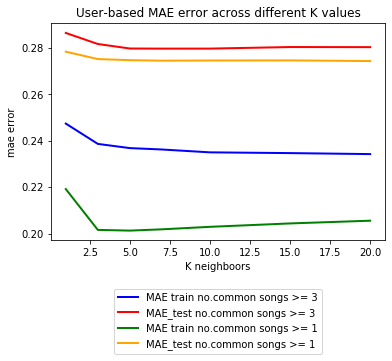

In [44]:
lw =2
import matplotlib.pyplot as plt
%matplotlib inline
K = [1,3,5,7,10,15,20]
mae_limit5 = [mae1, mae3, mae5, mae7, mae10, mae15, mae20]
mae_test_limit5 = [mae_1_test,mae_3_test, mae_5_test, mae_7_test, mae_10_test,mae_15_test,mae_20_test]
mae_limit1 = [mae1_T, mae3_T, mae5_T, mae7_T, mae10_T, mae15_T, mae20_T]
mae_test_limit1 = [mae_1_test_T,mae_3_test_T, mae_5_test_T, mae_7_test_T, mae_10_test_T,mae_15_test_T,mae_20_test_T]
plt.plot(K, mae_limit5, color = 'b',lw=lw, label = "MAE train no.common songs >= 3")
plt.plot(K, mae_test_limit5, color = 'r',lw=lw, label = "MAE_test no.common songs >= 3")
plt.plot(K, mae_limit1, color = 'green',lw=lw, label = "MAE train no.common songs >= 1")
plt.plot(K, mae_test_limit1, color = 'orange',lw=lw, label = "MAE_test no.common songs >= 1")
plt.xlabel("K neighboors")
plt.ylabel("mae error")
plt.title('User-based MAE error across different K values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()

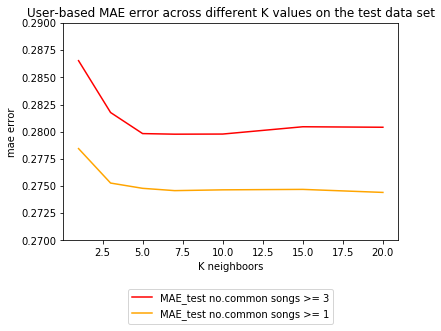

In [45]:
# plt.ylim(0.265,0.275) mae
import matplotlib.pyplot as plt
%matplotlib inline
K = [1,3,5,7,10,15,20]
mae_test_limit5 = [mae_1_test,mae_3_test, mae_5_test, mae_7_test, mae_10_test,mae_15_test,mae_20_test]
mae_test_limit1 = [mae_1_test_T,mae_3_test_T, mae_5_test_T, mae_7_test_T, mae_10_test_T,mae_15_test_T,mae_20_test_T]
plt.plot(K, mae_test_limit5, color = 'r', label = "MAE_test no.common songs >= 3")
plt.plot(K, mae_test_limit1, color = 'orange', label='MAE_test no.common songs >= 1')
plt.xlabel("K neighboors")
plt.ylabel("mae error")
plt.title('User-based MAE error across different K values on the test data set')
plt.ylim(0.27,0.29)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()

In [46]:
def commonS(k,neighboors):
    x = {}
    for i in user_songs_test.keys():
        cj = 0
        for w,j in neighboors[i][0][0:k]:
            cj+=1
        x[i] = cj
    return x


Text(0.5, 1.0, 'User-based CF: No of neighboors across users:common songs >=1')

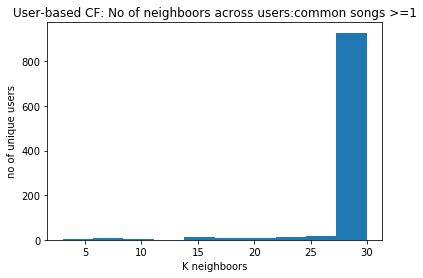

In [47]:
x = commonS(30,neighboors1)
plt.hist(x.values())
plt.xlabel("K neighboors")
plt.ylabel("no of unique users")
plt.title('User-based CF: No of neighboors across users:common songs >=1')

Text(0.5, 1.0, 'User-based CF: No of neighboors across users:common songs >=3')

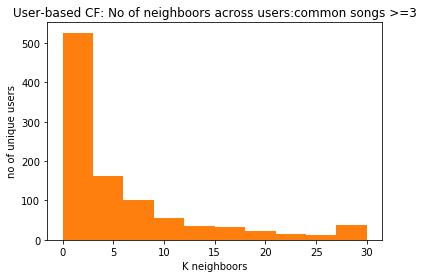

In [48]:
x = commonS(30,neighboors)
plt.hist(x.values())
plt.hist(x.values())
plt.xlabel("K neighboors")
plt.ylabel("no of unique users")
plt.title('User-based CF: No of neighboors across users:common songs >=3')